# DX 703 Final Project 12/7/2025

## Team Members: Peter Shmorhun, Emma Stiller, August Siu

### BU CDS - OMDS

This notebook implements a fine-tuned DistilBERT classifier for HuffPost news category prediction, incorporating EDA augmentation and back-translation to improve performance on minority classes.

### Base Imports 
(Note: For Reproducibility, HuffPost Dataset Must be Loaded), uncomment cell to download to local machine

In [7]:
"""
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))
"""

'\n# JSON mirror that preserves fields: headline, short_description, category, authors, link, date\nURL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"\nhuff_all = load_dataset("json", data_files=URL, split="train")\n\nprint(huff_all)\nprint("Columns:", huff_all.column_names)\nprint("Total rows:", len(huff_all))\n'

In [5]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# hugging face
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# load dataset
from datasets import load_from_disk
print("loading huffpost dataset")
huff_all = load_from_disk("huffpost_splits")  # reload when needed

loading huffpost dataset


### A.1 Setup & Context

#### Summary of Milestones 1 & 2

In **Milestone 1**, we performed EDA on the huffpost dataset, identified potential issues with class imblance, implemented a preprocessing strategy, and designed steps to mitigate overlapping class labeling to avoid difficult or vague labeling.

In **Milestone 2**, we performed experiments with various architectures, including a simple NN, CNN, and Destilbert fine-tune. We were able to improve model performance considerably from the baseline performance from ~61% to ~72%. 

#### Milestone 2 Model Performance Summary:

| Model | Accuracy | F1 (Weighted) | Training Time | Parameter Count |
| :--- | :--- | :--- | :--- | :--- |
| Baseline | 0.6168 | 0.5963 | 1:29 | 7,701,285 |
| Custom Architecture (CNN) | 0.6165 | 0.6116 | 13:24 | 11,842,085 |
| DistilBERT Fine-tune | 0.7199 | 0.7159 | 19:20 | 66,918,925 |

#### Hyperparameter Tuning & Optimization

During our **Milestone 2** modeling we performed extensive hyperparameter optimization experiments, including adjusting training parameters such as learning_rate adjustments, regularization optimization through dropout, vocabulary adjustments, and class weighting strategies. We noticed that controlling overfitting on the training set would be a considerable challenge, with visualizations consistently showing consistent divergence in train/val loss during training. This pattern persisted across architectures. 

We chose a Distilbert fine-tune at our architecture of choice because it offered the most performance at a reasonable level of computational cost. Larger transformer architectures, such as RoBERTa, actually performed worse on this dataset (our hypothesis is that the relatively short text sequences actually cause more confusion with RoBERTa). 

#### Learnings from Milestone 2

Pretrained transformers dramatically outperform training-from-scratch approaches. Experiments with class weighting strategies revealed that class imbalance significantly impacts minority class performance. Overall accuracy can be improved in some instances at the cost of degraded performance on minority classes. Granular error performance reporting of performance on minority classes revealed potential for additional class aggregation on overlapping categories. e.g., ("ARTS" vs "ARTS & CULTURE" vs "CULTURE & ARTS")

Outside research identified "Easy Data Augmentation" as a potential strategy to offer additional performance uplift. 

**Improvements for Final Model**

Based on Milestone 2 error analysis, we implement:

1. **Expanded Class Consolidation** - Merge semantically similar/duplicate categories (Milestone: 2 41 $\rightarrow$ 37, Final Model: 37 $\rightarrow$ 32)
2. **Easy Data Augmentation (EDA)** - Augment minority classes to reduce imbalance
3. **Refined Training Strategy** - Optimized hyperparameters based on M2 results

### Data Preprocessing 

This cell handles the entire data preparation flow:
1. Load raw data
2. Clean and combine text fields
3. Consolidate overlapping categories
4. Stratified train/val/test split
5. EDA + Back-translation augmentation on minority classes
6. Tokenization with DistilBERT
7. Label encoding and class weights


#### Notes: 
1. Specifics to the preprocessing loop are included below as comments
2. Data augmentation is only performed on the training set. 
3. BackTranslation Loop is Computationally Expensive (took more than 3 hours on my local machine... our datasets can be retrieved here), the block will check for the presence of the dataset in the project folder, then skip that step. 

In [ ]:
import numpy as np
import pandas as pd
import random
import pickle
import os
import time
from tqdm import tqdm
from collections import Counter

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import AutoTokenizer, MarianMTModel, MarianTokenizer

# For EDA augmentation
import nlpaug.augmenter.word as naw

print("A.1: Preprocessing Pipeline")
# Config
CONFIG = {
    'random_seed': 42,
    'max_length': 128,
    'test_size': 0.30,          # 30% held out for val+test
    'val_test_ratio': 0.50,     # Split held-out 50/50 into val and test
    'model_name': 'distilbert-base-uncased',

    # EDA Configuration (reduced to help with overfitting)
    'eda_min_class_size': 5000,   # Augment classes smaller than this
    'eda_num_augmentations': 1,   # Reduced from 2 to help with overfitting
    'eda_aug_probability': 0.15,  # Slightly more aggressive changes

    # Back-translation Configuration
    'use_backtranslation': True,  # Higher quality augmentation
    'backtrans_lang': 'De',       # Language for back-translation (German)
    
    # Caching - skip augmentation if cached file exists
    'augmented_cache_file': 'train_augmented_backtrans.parquet',
}

# Set random seeds for reproducibility
random.seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Class Consolidation Mapping
# Based on Milestone 2 confusion matrix analysis, merge semantically 
# similar or duplicate categories to create cleaner decision boundaries.

CLASS_MERGE_MAP = {
    # Exact duplicates / naming variations
    'ARTS': 'ARTS & CULTURE',
    'CULTURE & ARTS': 'ARTS & CULTURE',

    # Environmental content
    'GREEN': 'ENVIRONMENT',

    # World news variations  
    'WORLDPOST': 'WORLD NEWS',
    'THE WORLDPOST': 'WORLD NEWS',

    # Style/fashion
    'STYLE': 'STYLE & BEAUTY',

    # Parenting
    'PARENTS': 'PARENTING',

    # Food content
    'TASTE': 'FOOD & DRINK',

    # Health/wellness overlap (these had high confusion in M2)
    'HEALTHY LIVING': 'WELLNESS',
}

# Step 1: Load Raw Dataset
print("\n[1/7] Loading raw dataset...")

huff_all = load_from_disk("huffpost_splits")

def combine_fields(example):
    """Combine headline and short_description into single text field."""
    headline = example.get('headline', '') or ""
    short_desc = example.get('short_description', '') or "[NO_DESC]"
    example['text'] = f"{headline} [SEP] {short_desc}"
    return example

huff_all = huff_all.map(combine_fields)
df_raw = huff_all.to_pandas()
print(f"  Loaded {len(df_raw):,} samples")
print(f"  Original categories: {df_raw['category'].nunique()}")

# Step 2: Data Cleaning
print("\n[2/7] Cleaning data...")

df = df_raw.copy()

# Handle missing values
df['headline'] = df['headline'].fillna('')
df['short_description'] = df['short_description'].fillna('[NO_DESC]')
df['text'] = df['headline'] + " [SEP] " + df['short_description']

# Remove duplicates
original_len = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
print(f"  Removed {original_len - len(df):,} duplicates")
print(f"  Remaining samples: {len(df):,}")

# Step 3: Class Consolidation
print("\n[3/7] Consolidating overlapping categories...")

original_classes = df['category'].nunique()
df['category'] = df['category'].replace(CLASS_MERGE_MAP)
new_classes = df['category'].nunique()

print(f"  {original_classes} -> {new_classes} classes")
print(f"  Merged {original_classes - new_classes} redundant categories")

# Show new distribution
print("\n  Class distribution (top 10):")
for cat, count in df['category'].value_counts().head(10).items():
    print(f"    {cat}: {count:,}")

# STEP 4: Stratified Train/Val/Test Split
print("\n[4/7] Creating stratified splits...")

train_df, temp_df = train_test_split(
    df,
    test_size=CONFIG['test_size'],
    stratify=df['category'],
    random_state=CONFIG['random_seed']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=CONFIG['val_test_ratio'],
    stratify=temp_df['category'],
    random_state=CONFIG['random_seed']
)

print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")

# Step 5: Easy Data Augmentation (EDA) + Back-Translation
print("\n[5/7] Applying augmentation to minority classes...")

# Check for cached augmented data (for repeatability & faster runs)
if os.path.exists(CONFIG['augmented_cache_file']):
    print(f"  Found cached augmented data: {CONFIG['augmented_cache_file']}")
    print(f"  Loading from cache (skipping augmentation)...")
    train_df_aug = pd.read_parquet(CONFIG['augmented_cache_file'])
    print(f"  Loaded {len(train_df_aug):,} training samples from cache")
else:
    print(f"  No cache found. Running augmentation (this may take a while)...")
    
    # Initialize basic EDA augmenters
    aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p=CONFIG['eda_aug_probability'])
    aug_swap = naw.RandomWordAug(action='swap', aug_p=CONFIG['eda_aug_probability'])
    aug_delete = naw.RandomWordAug(action='delete', aug_p=CONFIG['eda_aug_probability'])
    basic_augmenters = [aug_synonym, aug_swap, aug_delete]

    # Initialize back-translation models
    backtrans_model = None
    backtrans_tokenizer = None
    reverse_model = None
    reverse_tokenizer = None

    if CONFIG['use_backtranslation']:
        print("  Loading back-translation models (English <-> German)...")
        import torch

        # Determine device
        if torch.cuda.is_available():
            bt_device = 'cuda'
        elif torch.backends.mps.is_available():
            bt_device = 'mps'
        else:
            bt_device = 'cpu'
        print(f"  Back-translation device: {bt_device}")

        lang = CONFIG['backtrans_lang']
        # English -> Target language
        backtrans_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-en-{lang}')
        backtrans_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-en-{lang}').to(bt_device)

        # Target language -> English
        reverse_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{lang}-en')
        reverse_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{lang}-en').to(bt_device)

        def back_translate(text, max_length=128):
            """Translate text to target language and back to English for paraphrasing."""
            try:
                # English to Target
                inputs = backtrans_tokenizer(text, return_tensors="pt", 
                                             padding=True, truncation=True, 
                                             max_length=max_length).to(bt_device)
                translated = backtrans_model.generate(**inputs, max_length=max_length)
                translated_text = backtrans_tokenizer.decode(translated[0], skip_special_tokens=True)

                # Target to English
                inputs = reverse_tokenizer(translated_text, return_tensors="pt",
                                           padding=True, truncation=True,
                                           max_length=max_length).to(bt_device)
                back_translated = reverse_model.generate(**inputs, max_length=max_length)
                result = reverse_tokenizer.decode(back_translated[0], skip_special_tokens=True)

                return result
            except Exception as e:
                return text  # Fallback to original on error

    def augment_text(text, num_aug=1, use_backtrans=True):
        """
        Apply augmentation to generate variations.
        Uses mix of basic EDA and back-translation for diversity.
        """
        augmented = []

        for i in range(num_aug):
            # Alternate between back-translation and basic EDA
            if use_backtrans and backtrans_model is not None and i % 2 == 0:
                # Use back-translation for higher quality paraphrases
                aug_text = back_translate(text)
            else:
                # Use basic EDA
                aug = random.choice(basic_augmenters)
                try:
                    result = aug.augment(text)
                    if isinstance(result, list):
                        result = result[0]
                    aug_text = result
                except:
                    aug_text = text

            augmented.append(aug_text)

        return augmented

    # Identify minority classes
    class_counts = train_df['category'].value_counts()
    minority_classes = class_counts[class_counts < CONFIG['eda_min_class_size']].index.tolist()

    print(f"  Minority classes to augment: {len(minority_classes)}")
    print(f"  Threshold: < {CONFIG['eda_min_class_size']:,} samples")
    print(f"  Back-translation enabled: {CONFIG['use_backtranslation']}")

    # Augment minority classes
    augmented_rows = []

    for cls in tqdm(minority_classes, desc="  Augmenting classes"):
        class_samples = train_df[train_df['category'] == cls]

        for _, row in class_samples.iterrows():
            aug_texts = augment_text(
                row['text'],
                num_aug=CONFIG['eda_num_augmentations'],
                use_backtrans=CONFIG['use_backtranslation']
            )
            for aug_text in aug_texts:
                new_row = row.copy()
                new_row['text'] = aug_text
                augmented_rows.append(new_row)

    # Combine original + augmented
    augmented_df = pd.DataFrame(augmented_rows)
    train_df_aug = pd.concat([train_df, augmented_df], ignore_index=True)

    print(f"\n  Original training samples: {len(train_df):,}")
    print(f"  Augmented samples added:   {len(augmented_df):,}")
    print(f"  Total training samples:    {len(train_df_aug):,}")
    
    # Save augmented dataset for future runs
    train_df_aug.to_parquet(CONFIG['augmented_cache_file'])
    print(f"  Saved augmented data to: {CONFIG['augmented_cache_file']}")

# Step 6: Label Encoding & Class Weights
print("\n[6/7] Encoding labels and computing class weights...")

le = LabelEncoder()
all_categories = (
    list(train_df_aug['category']) + 
    list(val_df['category']) + 
    list(test_df['category'])
)
le.fit(all_categories)
num_labels = len(le.classes_)

print(f"  Number of classes: {num_labels}")

# Compute class weights on augmented training set
categories = np.unique(train_df_aug['category'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=categories,
    y=train_df_aug['category']
)
print(f"  Class weights range: {class_weights.min():.2f} - {class_weights.max():.2f}")


# Step 7: Tokenization
print("\n[7/7] Tokenizing with DistilBERT...")

# Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df_aug[['text', 'category']], preserve_index=False)
val_ds = Dataset.from_pandas(val_df[['text', 'category']], preserve_index=False)
test_ds = Dataset.from_pandas(test_df[['text', 'category']], preserve_index=False)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

def tokenize_fn(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=CONFIG['max_length']
    )

# Tokenize all splits (uses DistilBERT tokenizer)
train_ds = train_ds.map(tokenize_fn, batched=True, batch_size=1000, desc="  Tokenizing train")
val_ds = val_ds.map(tokenize_fn, batched=True, batch_size=1000, desc="  Tokenizing val")
test_ds = test_ds.map(tokenize_fn, batched=True, batch_size=1000, desc="  Tokenizing test")

# Encode labels
def encode_labels(example):
    example['labels'] = le.transform([example['category']])[0]
    return example

train_ds = train_ds.map(encode_labels, desc="  Encoding train labels")
val_ds = val_ds.map(encode_labels, desc="  Encoding val labels")
test_ds = test_ds.map(encode_labels, desc="  Encoding test labels")

# Save Down Artifacts for Training
print("Preprocessing Complete")

# Save processed datasets
processed = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})
processed.save_to_disk("huffpost_final_processed")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save class weights
np.save('class_weights.npy', class_weights)

print(f"\nSaved artifacts:")
print(f"  - huffpost_final_processed/ (dataset)")
print(f"  - label_encoder.pkl")
print(f"  - class_weights.npy")
print(f"  - {CONFIG['augmented_cache_file']} (augmented text cache)")

print(f"\nFinal dataset sizes:")
print(f"  Train: {len(train_ds):,} (with augmentation)")
print(f"  Val:   {len(val_ds):,}")
print(f"  Test:  {len(test_ds):,}")
print(f"  Classes: {num_labels}")

A.1: Preprocessing Pipeline

[1/7] Loading raw dataset...
  Loaded 200,853 samples
  Original categories: 41

[2/7] Cleaning data...
  Removed 488 duplicates
  Remaining samples: 200,365

[3/7] Consolidating overlapping categories...
  41 -> 32 classes
  Merged 9 redundant categories

  Class distribution (top 10):
    POLITICS: 32,722
    WELLNESS: 24,510
    ENTERTAINMENT: 16,054
    PARENTING: 12,546
    STYLE & BEAUTY: 11,761
    TRAVEL: 9,883
    WORLD NEWS: 8,418
    FOOD & DRINK: 8,320
    QUEER VOICES: 6,310
    BUSINESS: 5,933

[4/7] Creating stratified splits...
  Train: 140,255 (70.0%)
  Val:   30,055 (15.0%)
  Test:  30,055 (15.0%)

[5/7] Applying augmentation to minority classes...
  Found cached augmented data: train_augmented_backtrans.parquet
  Loading from cache (skipping augmentation)...
  Loaded 193,561 training samples from cache

[6/7] Encoding labels and computing class weights...
  Number of classes: 32
  Class weights range: 0.26 - 4.30

[7/7] Tokenizing with Di

  Tokenizing train:   0%|          | 0/193561 [00:00<?, ? examples/s]

  Tokenizing val:   0%|          | 0/30055 [00:00<?, ? examples/s]

  Tokenizing test:   0%|          | 0/30055 [00:00<?, ? examples/s]

  Encoding train labels:   0%|          | 0/193561 [00:00<?, ? examples/s]

  Encoding val labels:   0%|          | 0/30055 [00:00<?, ? examples/s]

  Encoding test labels:   0%|          | 0/30055 [00:00<?, ? examples/s]

Preprocessing Complete


Saving the dataset (0/1 shards):   0%|          | 0/193561 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/30055 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/30055 [00:00<?, ? examples/s]


Saved artifacts:
  - huffpost_final_processed/ (dataset)
  - label_encoder.pkl
  - class_weights.npy
  - train_augmented_backtrans.parquet (augmented text cache)

Final dataset sizes:
  Train: 193,561 (with augmentation)
  Val:   30,055
  Test:  30,055
  Classes: 32


### A.2: Model Selection and Retraining

**Final model:** DistilBERT fine-tuned for sequence classification
- Selected based on Milestone 2 results: 72.2% accuracy vs 61.7% baseline

#### Improvements over M2:

- Early stopping on val_loss (not accuracy) to prevent overfitting
- Increased weight_decay for regularization
- Back-translation augmentation for better generalization

#### Hyperparameter Definitions (seen in variable `TRAIN_CONFIG`)

1. Batch Size: 16
2. Learning Rate: 2e-5
3. Epochs: 5
4. Warmup Ratio: 0.1
5. Weight Decay: 0.05
6. Max Gradient Normalization: 1.0 (used to control gradient clipping)
7. Patience: 2
8. Dropout: 0.1 (DistilBERT internal default, applied in attention and feed-forward layers)

#### Optimization Strategy

**AdamW** - Chosen because it is appropriate for transformer fine-tuning and includes decoupled weight decay

#### Callbacks

We used the following techniques were used to control overfitting and ensure model training stability:

1. **early stopping/patience** - Used to control overfitting, set to kick in after 2 epochs with no improvement.
2. **checkpointing** - Model weights are saved following each epoch, weights are rolled back to the optimal model following early stopping.
3. **warmup** - A Torch strategy for learning rate adjustment during early training. It involves gradually increasing the learning rate from a small value to a target value over a specified number of iterations or epochs. 

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import time
import numpy as np
import pickle
from datasets import load_from_disk

print("A.2: Model Selection and Retraining")

# TRAINING CONFIGURATION
TRAIN_CONFIG = {
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.05,       # Increased from 0.01 for regularization
    'max_grad_norm': 1.0,
    'patience': 2,              # Early stopping patience (on val_loss)
}

print("\nTraining Configuration:")
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")

# Load Data
print("\n[1/4] Loading preprocessed dataset...")

processed_datasets = load_from_disk("huffpost_final_processed")
train_ds = processed_datasets['train']
val_ds = processed_datasets['validation']
test_ds = processed_datasets['test']

# Load label encoder and class weights
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

class_weights = np.load('class_weights.npy')
num_labels = len(le.classes_)

print(f"  Train: {len(train_ds):,} samples")
print(f"  Val:   {len(val_ds):,} samples")
print(f"  Test:  {len(test_ds):,} samples")
print(f"  Classes: {num_labels}")

# Set format for PyTorch (data already tokenized in A.1)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# MODEL SETUP
print("\n[2/4] Loading pretrained DistilBERT model...")

# Device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"  Device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="single_label_classification"
)
model = model.to(device)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# TRAINING SETUP
print("\n[3/4] Configuring optimizer and scheduler...")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=TRAIN_CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=TRAIN_CONFIG['batch_size'])
test_loader = DataLoader(test_ds, batch_size=TRAIN_CONFIG['batch_size'])

# Loss function (no class weights - they hurt performance in M2 experiments)
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=TRAIN_CONFIG['learning_rate'],
    weight_decay=TRAIN_CONFIG['weight_decay']
)

# Learning rate scheduler with linear warmup
total_steps = len(train_loader) * TRAIN_CONFIG['epochs']
warmup_steps = int(total_steps * TRAIN_CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"  Total training steps: {total_steps:,}")
print(f"  Warmup steps: {warmup_steps:,}")
print(f"  Train batches/epoch: {len(train_loader):,}")
print(f"  Val batches/epoch: {len(val_loader):,}")

# TRAINING FUNCTIONS
def train_epoch(model, loader, criterion, optimizer, scheduler, device, max_grad_norm):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{100*correct/total:.1f}%'})

    return total_loss / len(loader), 100 * correct / total


def evaluate(model, loader, criterion, device):
    """Evaluate on validation/test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

# TRAINING LOOP (with early stopping on val_loss)
print("\n[4/4] Starting training...")
print(f"    Early stopping: patience={TRAIN_CONFIG['patience']} epochs (based on val_loss)")

start_time = time.time()
best_val_acc = 0
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

# Track history for plotting
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(TRAIN_CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{TRAIN_CONFIG['epochs']}:")

    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler,
        device, TRAIN_CONFIG['max_grad_norm']
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"  Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.3f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Train-Val Gap: {train_acc - val_acc:.2f}%")

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        model.save_pretrained('best_distilbert_final')
        tokenizer.save_pretrained('best_distilbert_final')
        print(f"  >> New best model saved! (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  >> No improvement. Patience: {patience_counter}/{TRAIN_CONFIG['patience']}")
        if patience_counter >= TRAIN_CONFIG['patience']:
            print(f"\n  >> Early stopping triggered at epoch {epoch+1}")
            break

training_time = time.time() - start_time

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
print(f"Training time: {training_time:.2f}s ({training_time/60:.1f} min)")
print(f"Best epoch: {best_epoch + 1}")
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Best val accuracy: {best_val_acc:.2f}%")
print(f"Stopped at epoch: {len(history['train_loss'])}")

# Overfitting analysis
train_acc_at_best = history['train_acc'][best_epoch]
val_acc_at_best = history['val_acc'][best_epoch]
overfitting_gap = train_acc_at_best - val_acc_at_best

print(f"\nOverfitting Analysis:")
print(f"  Train acc at best: {train_acc_at_best:.2f}%")
print(f"  Val acc at best:   {val_acc_at_best:.2f}%")
print(f"  Gap: {overfitting_gap:.2f}%")

A.2: Model Selection and Retraining

Training Configuration:
  batch_size: 16
  learning_rate: 2e-05
  epochs: 5
  warmup_ratio: 0.1
  weight_decay: 0.05
  max_grad_norm: 1.0
  patience: 2

[1/4] Loading preprocessed dataset...
  Train: 193,561 samples
  Val:   30,055 samples
  Test:  30,055 samples
  Classes: 32

[2/4] Loading pretrained DistilBERT model...
  Device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Total parameters: 66,978,080
  Trainable parameters: 66,978,080

[3/4] Configuring optimizer and scheduler...
  Total training steps: 60,490
  Warmup steps: 6,049
  Train batches/epoch: 12,098
  Val batches/epoch: 1,879

[4/4] Starting training...
    Early stopping: patience=2 epochs (based on val_loss)

Epoch 1/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 169.65it/s]


  Train Loss: 1.483 | Train Acc: 60.51%
  Val Loss:   0.941 | Val Acc:   72.87%
  Train-Val Gap: -12.35%
  >> New best model saved! (val_loss: 0.9415)

Epoch 2/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 169.42it/s]


  Train Loss: 0.759 | Train Acc: 78.01%
  Val Loss:   0.940 | Val Acc:   73.55%
  Train-Val Gap: 4.46%
  >> New best model saved! (val_loss: 0.9401)

Epoch 3/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 169.34it/s]


  Train Loss: 0.459 | Train Acc: 86.67%
  Val Loss:   1.047 | Val Acc:   73.50%
  Train-Val Gap: 13.17%
  >> No improvement. Patience: 1/2

Epoch 4/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 169.40it/s]

  Train Loss: 0.270 | Train Acc: 92.25%
  Val Loss:   1.226 | Val Acc:   73.55%
  Train-Val Gap: 18.70%
  >> No improvement. Patience: 2/2

  >> Early stopping triggered at epoch 4

TRAINING COMPLETE
Training time: 1257.08s (21.0 min)
Best epoch: 2
Best val loss: 0.9401
Best val accuracy: 73.55%
Stopped at epoch: 4

Overfitting Analysis:
  Train acc at best: 78.01%
  Val acc at best:   73.55%
  Gap: 4.46%


### A.3: Evaluation and Visualization

This section evaluates the trained model on the held-out test set and generates visualizations including:
- Training vs validation curves (loss and accuracy)
- Confusion matrix
- Per-class performance metrics
- Comparison with Milestone 2 results

The **validation split** is used in the training loop. For each epoch, we evaluated and tracked model accuracy and loss against the validation set (included in the above logging). We observed validation set performance to track potential overfitting, and used these metrics to trigger early stopping.

The test set is completely held out until final evaluation. We evaluate test set performance using the torch cross entropy loss function, then produce final evaluation metrics, including test accuracy, test loss, macro f1, and weighted f1. These metrics are appropriate to evaluate the models performance on the dataset as a whole, as well as specific performance on the minority classes.

Notes:
1. Visualizations and Test metrics are all included in the printed statements below. 

A.3: Evaluation and Visualization

[1/4] Generating training curves...


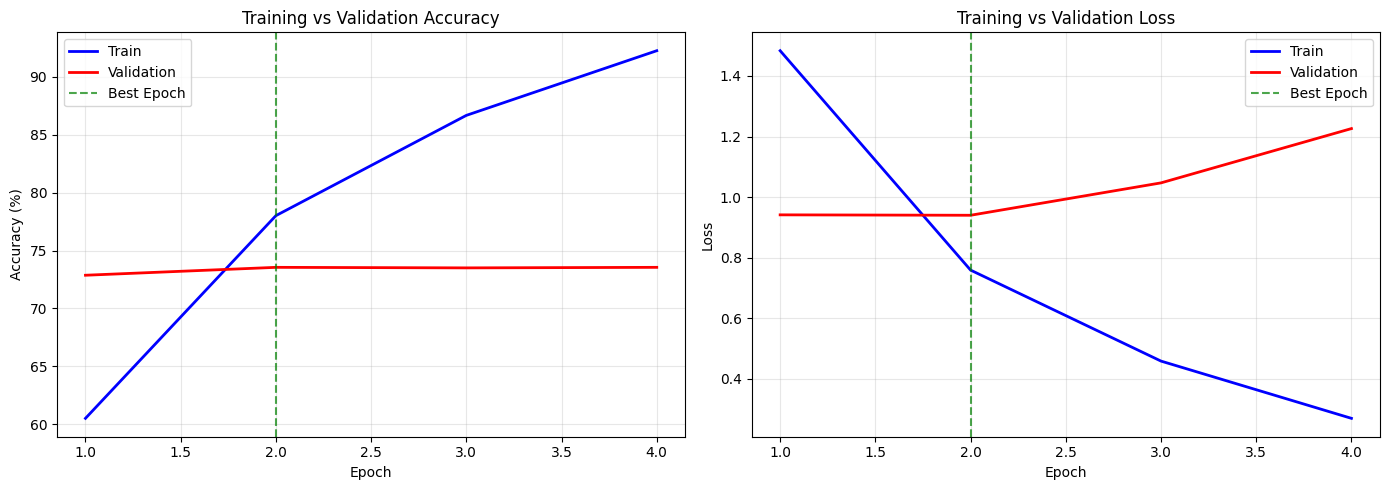


[2/4] Evaluating on test set...


Testing: 100%|██████████| 1879/1879 [00:10<00:00, 171.46it/s]



FINAL TEST METRICS
Test Accuracy:  73.87%
Test Loss:      0.9379
Macro F1:       0.6517
Weighted F1:    0.7399

[3/4] Generating confusion matrix (row-normalized for recall)...


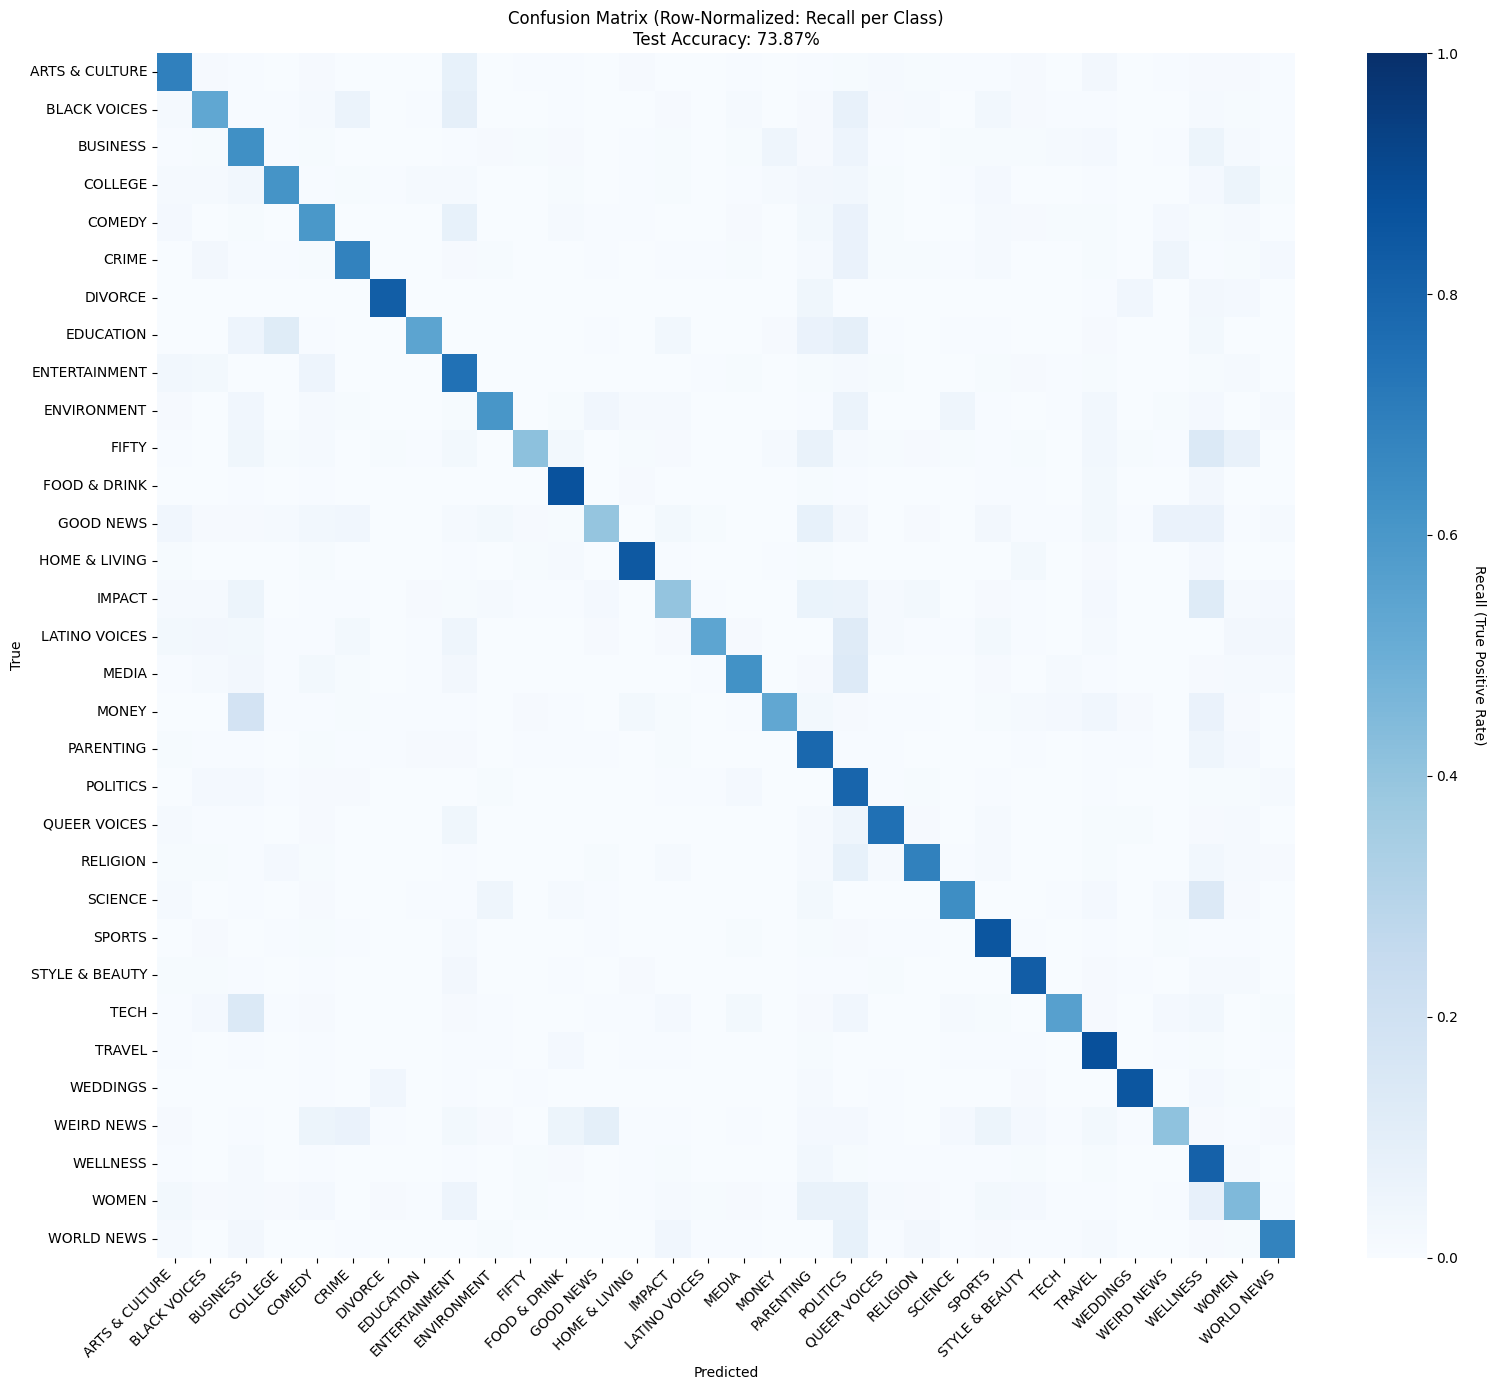


Top 10 Most Confused Class Pairs (off-diagonal):
------------------------------------------------------------
True Class                Predicted As                  Rate    Count
------------------------------------------------------------
MONEY                     BUSINESS                    18.4%       47
FIFTY                     WELLNESS                    14.3%       30
TECH                      BUSINESS                    14.1%       43
SCIENCE                   WELLNESS                    13.8%       45
MEDIA                     POLITICS                    13.3%       56
IMPACT                    WELLNESS                    12.5%       65
LATINO VOICES             POLITICS                    12.4%       21
EDUCATION                 COLLEGE                     12.0%       18
WEIRD NEWS                GOOD NEWS                    9.5%       38
EDUCATION                 POLITICS                     9.3%       14

[4/4] Per-class performance:
--------------------------------------

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
import pickle
from datasets import load_from_disk

print("A.3: Evaluation and Visualization")

# Load data and model artifacts
processed_datasets = load_from_disk("huffpost_final_processed")
test_ds = processed_datasets['test']

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

num_labels = len(le.classes_)

# Set format for PyTorch
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Load best model
model = AutoModelForSequenceClassification.from_pretrained('best_distilbert_final').to(device)
model.eval()

test_loader = DataLoader(test_ds, batch_size=16)
criterion = nn.CrossEntropyLoss()

# Training Curves Visualization
print("\n[1/4] Generating training curves...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_acc'])+1)

# Accuracy curves
axes[0].plot(epochs_range, history['train_acc'], 'b-', linewidth=2, label='Train')
axes[0].plot(epochs_range, history['val_acc'], 'r-', linewidth=2, label='Validation')
axes[0].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label='Best Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss curves
axes[1].plot(epochs_range, history['train_loss'], 'b-', linewidth=2, label='Train')
axes[1].plot(epochs_range, history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[1].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label='Best Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Test Set Evaluation
print("\n[2/4] Evaluating on test set...")

all_preds = []
all_labels = []
test_loss_total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        test_loss_total += loss.item()

        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss_total / len(test_loader)
test_acc = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

# Calculate metrics
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n{'='*50}")
print("FINAL TEST METRICS")
print(f"{'='*50}")
print(f"Test Accuracy:  {test_acc:.2f}%")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Macro F1:       {macro_f1:.4f}")
print(f"Weighted F1:    {weighted_f1:.4f}")

# Confusion Matrix Generation (Row-normalized to show recall per class)
print("\n[3/4] Generating confusion matrix (row-normalized for recall)...")

cm = confusion_matrix(all_labels, all_preds)

# Row-normalize: each row sums to 1 (shows recall/TPR per class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Row-Normalized: Recall per Class)\nTest Accuracy: {test_acc:.2f}%')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add colorbar label
cbar = plt.gca().collections[0].colorbar
cbar.set_label('Recall (True Positive Rate)', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Show top confused class pairs
print("\nTop 10 Most Confused Class Pairs (off-diagonal):")
print("-" * 60)

# Get off-diagonal confusion values
confused_pairs = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j and cm_normalized[i, j] > 0.05:  # >5% confusion rate
            confused_pairs.append((le.classes_[i], le.classes_[j], cm_normalized[i, j], cm[i, j]))

# Sort by confusion rate
confused_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"{'True Class':<25} {'Predicted As':<25} {'Rate':>8} {'Count':>8}")
print("-" * 60)
for true_cls, pred_cls, rate, count in confused_pairs[:10]:
    print(f"{true_cls:<25} {pred_cls:<25} {rate:>7.1%} {count:>8}")

# Per-Class Performance
print("\n[4/4] Per-class performance:")
print("-" * 80)

y_pred_categories = le.inverse_transform(all_preds)
y_true_categories = le.inverse_transform(all_labels)

print(classification_report(y_true_categories, y_pred_categories,
                          target_names=le.classes_, digits=4))

# Comparison with Previous Models
print("\n" + "=" * 70)
print("Comparison with Previous Models (Milestone 2)")
print("=" * 70)

m2_results = {
    'Baseline (Embedding+Pool)': {'acc': 61.68, 'macro_f1': 0.4663, 'time': '82s'},
    'Custom TextCNN': {'acc': 61.85, 'macro_f1': 0.5027, 'time': '801s'},
    'DistilBERT (M2)': {'acc': 72.24, 'macro_f1': 0.6319, 'time': '1292s'},
}

print(f"\n{'Model':<35} {'Accuracy':<12} {'Macro F1':<12} {'Time':<10}")
print("-" * 70)
for model_name, metrics in m2_results.items():
    print(f"{model_name:<35} {metrics['acc']:<12.2f} {metrics['macro_f1']:<12.4f} {metrics['time']:<10}")
print(f"{'DistilBERT + BackTrans + EarlySto':<35} {test_acc:<12.2f} {macro_f1:<12.4f} {f'{training_time:.0f}s':<10}")

improvement = test_acc - m2_results['DistilBERT (M2)']['acc']
print(f"\nImprovement over M2 DistilBERT: {improvement:+.2f}%")
print(f"Overfitting gap at best epoch: {overfitting_gap:.2f}% (target: <15%)")

### Acknowledgments, AI Use Policy

**[EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks](https://aclanthology.org/D19-1670/) (Wei & Zou, EMNLP-IJCNLP 2019)**

- This paper was used to inform the "Easy Data Augmentation" approach

**Auerlien Geron. "Hands-on Machine Learning with Scikit-Learn and PyTorch". O'Reilly Books, 2025, https://www.oreilly.com/library/view/hands-on-machine-learning/9798341607972/**

The 2nd Edition of Hands-on Machine Learning uses PyTorch, rather than tensorflow. The torch backend is easier to maintain from a dependency standpoint when working locally. The Torch Objects for the training loop, such as the dataloader, loss functions, and evaluation code, were adapted from the following chapters:

| HoML chapter | Github Link |
| :--- | :--- |
| Chapter 10 - Building Neural Networks with PyTorch | https://github.com/ageron/handson-mlp/blob/main/10_neural_nets_with_pytorch.ipynb |
| Chapter 11 - Training Deep Neural Networks | https://github.com/ageron/handson-mlp/blob/main/11_training_deep_neural_networks.ipynb |
| Chapter 14 - Natural Language Processing with RNNs and Attention | https://github.com/ageron/handson-mlp/blob/main/14_nlp_with_rnns_and_attention.ipynb |
| Chapter 15 - Transformers for Natural Language Processing and Chatbots | https://github.com/ageron/handson-mlp/blob/main/15_transformers_for_nlp_and_chatbots.ipynb |


### Easy Data Augmentation

#### NLPAUG library
- https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb 
- https://github.com/makcedward/nlpaug/tree/master

#### MarianMT - Used for BackTranslation
- MarianTokenizer - https://huggingface.co/docs/transformers/en/model_doc/marian


### Generative AI Acknowledgements
Anthropic Claude 4.5 was used to help design the Easy Data Augmentation & Back Translation loop (which was computationally expensive), to nest within the existing preprocessing loop and to add checkpointing/file saves:

        # Step 5: Easy Data Augmentation (EDA) + Back-Translation
        print("\n[5/7] Applying augmentation to minority classes...")

        # Check for cached augmented data (for repeatability & faster runs)
        if os.path.exists(CONFIG['augmented_cache_file']):
            print(f"  Found cached augmented data: {CONFIG['augmented_cache_file']}")
            print(f"  Loading from cache (skipping augmentation)...")
            train_df_aug = pd.read_parquet(CONFIG['augmented_cache_file'])
            print(f"  Loaded {len(train_df_aug):,} training samples from cache")
        else:
            print(f"  No cache found. Running augmentation (this may take a while)...")
            
            # Initialize basic EDA augmenters
            aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p=CONFIG['eda_aug_probability'])
            aug_swap = naw.RandomWordAug(action='swap', aug_p=CONFIG['eda_aug_probability'])
            aug_delete = naw.RandomWordAug(action='delete', aug_p=CONFIG['eda_aug_probability'])
            basic_augmenters = [aug_synonym, aug_swap, aug_delete]

            # Initialize back-translation models
            backtrans_model = None
            backtrans_tokenizer = None
            reverse_model = None
            reverse_tokenizer = None

            if CONFIG['use_backtranslation']:
                print("  Loading back-translation models (English <-> German)...")
                import torch

                # Determine device
                if torch.cuda.is_available():
                    bt_device = 'cuda'
                elif torch.backends.mps.is_available():
                    bt_device = 'mps'
                else:
                    bt_device = 'cpu'
                print(f"  Back-translation device: {bt_device}")

                lang = CONFIG['backtrans_lang']
                # English -> Target language
                backtrans_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-en-{lang}')
                backtrans_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-en-{lang}').to(bt_device)

                # Target language -> English
                reverse_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{lang}-en')
                reverse_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{lang}-en').to(bt_device)

                def back_translate(text, max_length=128):
                    """Translate text to target language and back to English for paraphrasing."""
                    try:
                        # English to Target
                        inputs = backtrans_tokenizer(text, return_tensors="pt", 
                                                    padding=True, truncation=True, 
                                                    max_length=max_length).to(bt_device)
                        translated = backtrans_model.generate(**inputs, max_length=max_length)
                        translated_text = backtrans_tokenizer.decode(translated[0], skip_special_tokens=True)

                        # Target to English
                        inputs = reverse_tokenizer(translated_text, return_tensors="pt",
                                                padding=True, truncation=True,
                                                max_length=max_length).to(bt_device)
                        back_translated = reverse_model.generate(**inputs, max_length=max_length)
                        result = reverse_tokenizer.decode(back_translated[0], skip_special_tokens=True)

                        return result
                    except Exception as e:
                        return text  # Fallback to original on error

            def augment_text(text, num_aug=1, use_backtrans=True):
                """
                Apply augmentation to generate variations.
                Uses mix of basic EDA and back-translation for diversity.
                """
                augmented = []

                for i in range(num_aug):
                    # Alternate between back-translation and basic EDA
                    if use_backtrans and backtrans_model is not None and i % 2 == 0:
                        # Use back-translation for higher quality paraphrases
                        aug_text = back_translate(text)
                    else:
                        # Use basic EDA
                        aug = random.choice(basic_augmenters)
                        try:
                            result = aug.augment(text)
                            if isinstance(result, list):
                                result = result[0]
                            aug_text = result
                        except:
                            aug_text = text

                    augmented.append(aug_text)

                return augmented

            # Identify minority classes
            class_counts = train_df['category'].value_counts()
            minority_classes = class_counts[class_counts < CONFIG['eda_min_class_size']].index.tolist()

            print(f"  Minority classes to augment: {len(minority_classes)}")
            print(f"  Threshold: < {CONFIG['eda_min_class_size']:,} samples")
            print(f"  Back-translation enabled: {CONFIG['use_backtranslation']}")

            # Augment minority classes
            augmented_rows = []

            for cls in tqdm(minority_classes, desc="  Augmenting classes"):
                class_samples = train_df[train_df['category'] == cls]

                for _, row in class_samples.iterrows():
                    aug_texts = augment_text(
                        row['text'],
                        num_aug=CONFIG['eda_num_augmentations'],
                        use_backtrans=CONFIG['use_backtranslation']
                    )
                    for aug_text in aug_texts:
                        new_row = row.copy()
                        new_row['text'] = aug_text
                        augmented_rows.append(new_row)

            # Combine original + augmented
            augmented_df = pd.DataFrame(augmented_rows)
            train_df_aug = pd.concat([train_df, augmented_df], ignore_index=True)

            print(f"\n  Original training samples: {len(train_df):,}")
            print(f"  Augmented samples added:   {len(augmented_df):,}")
            print(f"  Total training samples:    {len(train_df_aug):,}")
            
            # Save augmented dataset for future runs
            train_df_aug.to_parquet(CONFIG['augmented_cache_file'])
            print(f"  Saved augmented data to: {CONFIG['augmented_cache_file']}")


